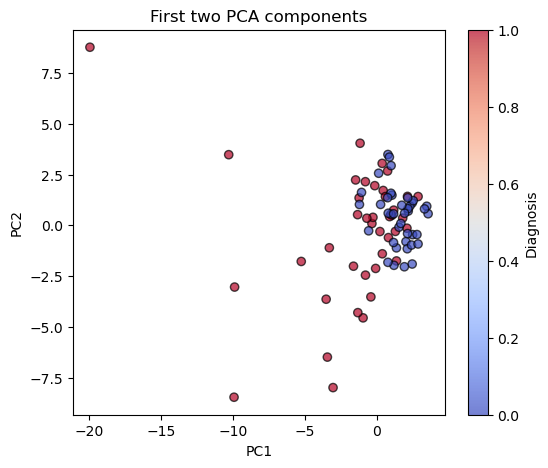

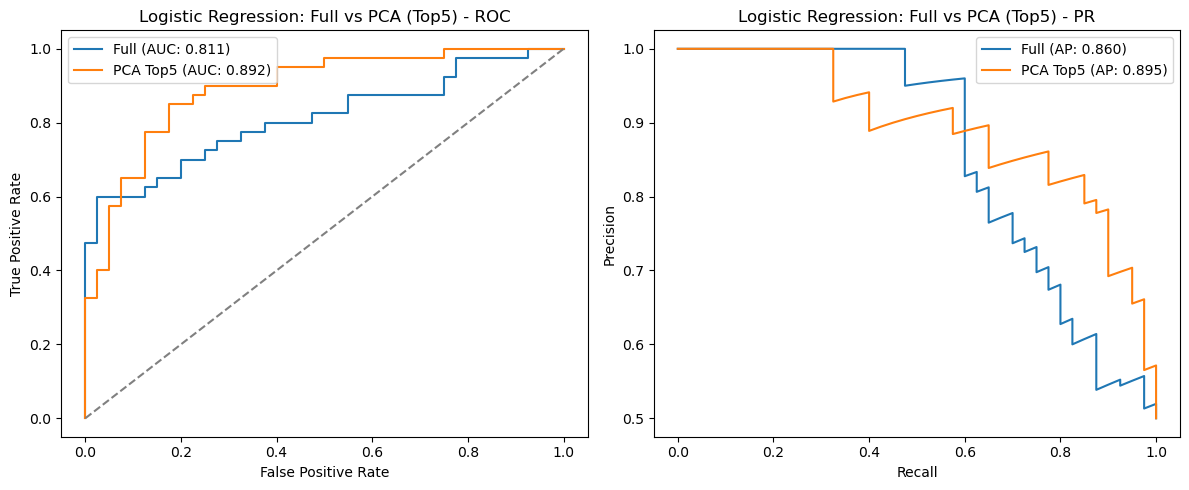

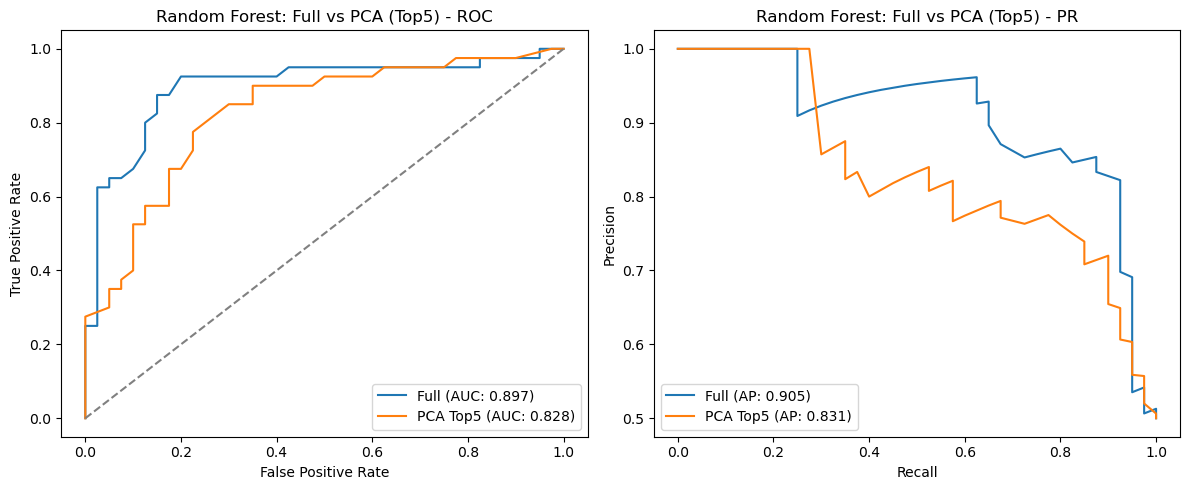

=== Logistic Regression (Full vs PCA) ===
Full: ROC AUC = 0.811, PR AUC = 0.860
PCA Top5: ROC AUC = 0.892, PR AUC = 0.895

=== Random Forest (Full vs PCA) ===
Full: ROC AUC = 0.897, PR AUC = 0.905
PCA Top5: ROC AUC = 0.828, PR AUC = 0.831


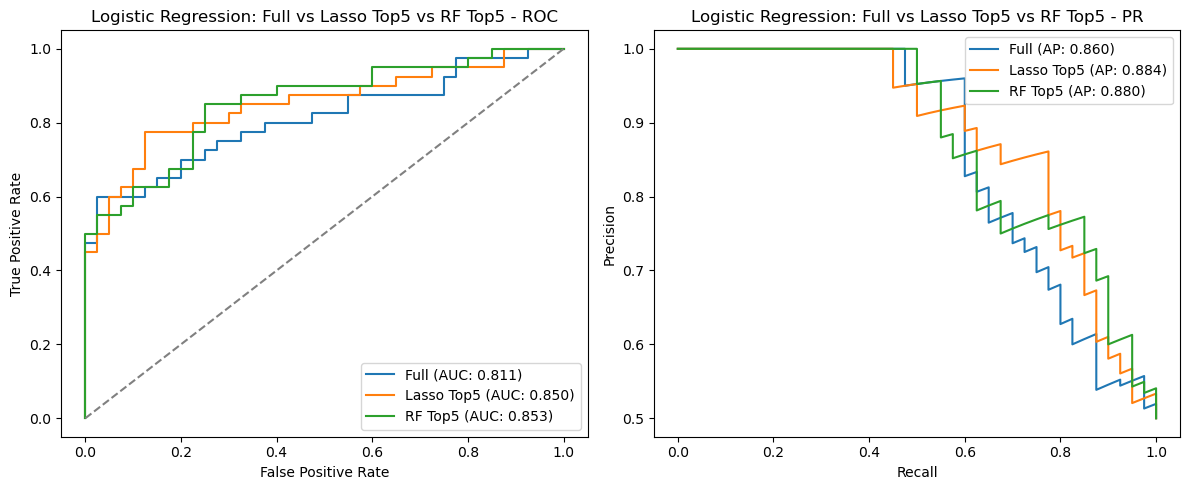

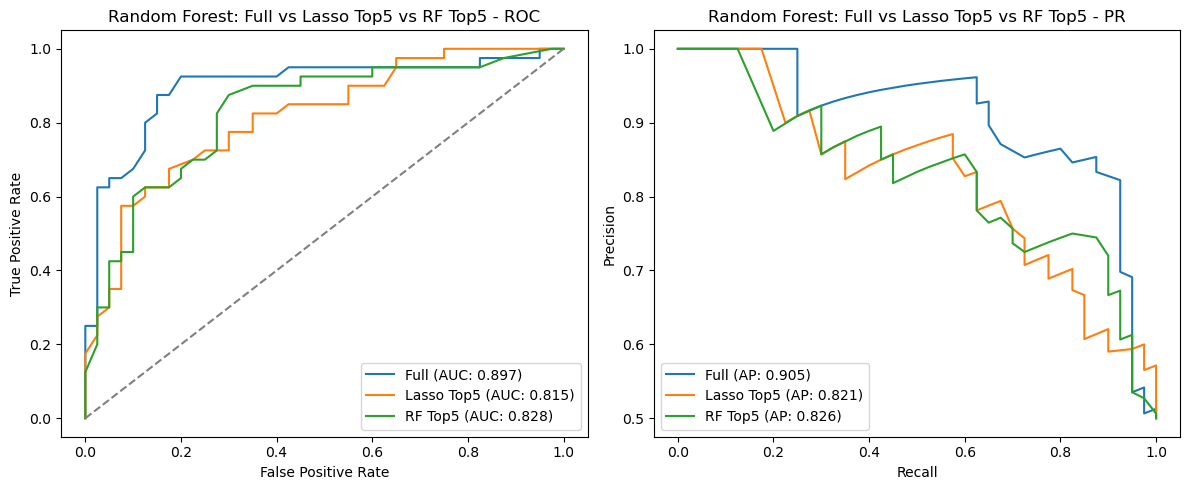


=== Logistic Regression (Full vs Lasso vs RF Feature Selection) ===
Full: ROC AUC = 0.811, PR AUC = 0.860
Lasso Top5: ROC AUC = 0.850, PR AUC = 0.884
RF Top5: ROC AUC = 0.853, PR AUC = 0.880

=== Random Forest (Full vs Lasso vs RF Feature Selection) ===
Full: ROC AUC = 0.897, PR AUC = 0.905
Lasso Top5: ROC AUC = 0.815, PR AUC = 0.821
RF Top5: ROC AUC = 0.828, PR AUC = 0.826


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from sklearn.pipeline import Pipeline

# ========================================================
# (0) Load SPECTF Dataset
# ========================================================
column_names = ["diagnosis"] + [f"F{i}{s}" for i in range(1,23) for s in ("R","S")]

data = pd.read_csv("spectf.train", header=None, names=column_names)

y = data["diagnosis"].values
X = data.drop(columns=["diagnosis"]).values

# ========================================================
# Helper Functions
# ========================================================
def evaluate_model(X, y, model, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    y_prob = cross_val_predict(model, X, y, cv=skf, method='predict_proba')
    fpr, tpr, _ = roc_curve(y, y_prob[:, 1])
    precision, recall, _ = precision_recall_curve(y, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    pr_auc = average_precision_score(y, y_prob[:, 1])
    return fpr, tpr, precision, recall, roc_auc, pr_auc

def plot_curves(results, title_prefix):
    plt.figure(figsize=(12,5))
    # ROC Curve
    plt.subplot(1,2,1)
    for label, (fpr, tpr, _, _, roc_auc, _) in results.items():
        plt.plot(fpr, tpr, label=f'{label} (AUC: {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix} - ROC')
    plt.legend()

    # PR Curve
    plt.subplot(1,2,2)
    for label, (_, _, precision, recall, _, pr_auc) in results.items():
        plt.plot(recall, precision, label=f'{label} (AP: {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title_prefix} - PR')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Models to use
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ========================================================
# (1) PCA
# - Perform PCA on the dataset without the target column
# - Plot first two components
# - Extract first 5 PCA components and evaluate models
# ========================================================

# Scale data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot first two principal components
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCA components')
plt.colorbar(label='Diagnosis')
plt.show()


# Extract first 5 components
X_pca_5 = X_pca[:, :5]

# Evaluate Logistic Regression & RF on full data
pipe_full_lr = Pipeline([('scaler', StandardScaler()), ('clf', log_reg)])
pipe_full_rf = Pipeline([('scaler', StandardScaler()), ('clf', rf_clf)])

res_full_lr = evaluate_model(X, y, pipe_full_lr)
res_full_rf = evaluate_model(X, y, pipe_full_rf)

# Evaluate Logistic Regression & RF on first 5 PCA components
# Note: The data is already scaled before PCA, but we include a scaler in pipeline for consistency.
pipe_pca_lr = Pipeline([('clf', LogisticRegression(max_iter=1000, random_state=42))])
pipe_pca_rf = Pipeline([('clf', RandomForestClassifier(n_estimators=100, random_state=42))])

res_pca_lr = evaluate_model(X_pca_5, y, pipe_pca_lr)
res_pca_rf = evaluate_model(X_pca_5, y, pipe_pca_rf)

# Compare results (Full vs PCA Top5)
lr_results_pca = {
    'Full': res_full_lr,
    'PCA Top5': res_pca_lr
}
plot_curves(lr_results_pca, "Logistic Regression: Full vs PCA (Top5)")

rf_results_pca = {
    'Full': res_full_rf,
    'PCA Top5': res_pca_rf
}
plot_curves(rf_results_pca, "Random Forest: Full vs PCA (Top5)")

print("=== Logistic Regression (Full vs PCA) ===")
for key, (_, _, _, _, roc_auc, pr_auc) in lr_results_pca.items():
    print(f"{key}: ROC AUC = {roc_auc:.3f}, PR AUC = {pr_auc:.3f}")

print("\n=== Random Forest (Full vs PCA) ===")
for key, (_, _, _, _, roc_auc, pr_auc) in rf_results_pca.items():
    print(f"{key}: ROC AUC = {roc_auc:.3f}, PR AUC = {pr_auc:.3f}")

# ========================================================
# (2) Feature Selection with Lasso and RF
# ========================================================
# Pipelines for feature selection and model training within CV to avoid data leakage.

# Lasso-based feature selection pipelines
pipe_lasso_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_select', SelectFromModel(Lasso(alpha=0.01, random_state=42), max_features=5)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_lasso_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_select', SelectFromModel(Lasso(alpha=0.01, random_state=42), max_features=5)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

res_lasso_lr = evaluate_model(X, y, pipe_lasso_lr)
res_lasso_rf = evaluate_model(X, y, pipe_lasso_rf)

# RF-based feature selection pipelines
pipe_rfsel_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_select', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), max_features=5)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_rfsel_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_select', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), max_features=5)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

res_rfsel_lr = evaluate_model(X, y, pipe_rfsel_lr)
res_rfsel_rf = evaluate_model(X, y, pipe_rfsel_rf)

# Compare models trained on full data vs Lasso Top5 vs RF Top5
lr_results_fs = {
    'Full': res_full_lr,
    'Lasso Top5': res_lasso_lr,
    'RF Top5': res_rfsel_lr
}
plot_curves(lr_results_fs, "Logistic Regression: Full vs Lasso Top5 vs RF Top5")

rf_results_fs = {
    'Full': res_full_rf,
    'Lasso Top5': res_lasso_rf,
    'RF Top5': res_rfsel_rf
}
plot_curves(rf_results_fs, "Random Forest: Full vs Lasso Top5 vs RF Top5")

print("\n=== Logistic Regression (Full vs Lasso vs RF Feature Selection) ===")
for key, (_, _, _, _, roc_auc, pr_auc) in lr_results_fs.items():
    print(f"{key}: ROC AUC = {roc_auc:.3f}, PR AUC = {pr_auc:.3f}")

print("\n=== Random Forest (Full vs Lasso vs RF Feature Selection) ===")
for key, (_, _, _, _, roc_auc, pr_auc) in rf_results_fs.items():
    print(f"{key}: ROC AUC = {roc_auc:.3f}, PR AUC = {pr_auc:.3f}")
